# Explore Southern Ocean - East Pacific Teleconnection
Examine how this is mediated by SWCF

In [1]:
import numpy as np
import xarray as xr
import xcdat as xc
import xskillscore as xscore
from scipy.stats import linregress

from typing import Tuple

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import matplotlib as mpl

# Utils

In [2]:
def get_triangle(tos, latmin: float = -38.75, latmax: float = -1.25, lonmin: float = -178.75, lonmax: float = -71.25, RES: float = 2.5):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ctos = tos.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))
    nmodel, ntime, _, nlon = ctos.shape
    # print(ctos)

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == nlon: break

        # print("j prior: ", j)
        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
             
        # print("j: ", j)
        nlats = int(len(latcoords) - j) # nlats below diag
        # print("nlats: ", nlats)
        ctos[:,:,:nlats,i] = np.full((nmodel, ntime, nlats), np.nan) 
        
        jold = j
    
    return ctos

def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)

def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def fix_coords_no_time(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = xc.swap_lon_axis(data, to=(0, 360))
    return data

def fix_coords_no_space(data):
    data = data.bounds.add_bounds("T")
    return data

def fix_coords_no_swap(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    return data


In [3]:
def _global_plot(ax, data, lon, lat, cmap, pvalues=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1), cbar_label: str = ""):
    # plot map of global data with central longitude 180
    # Uncomment for reds
    cmap = matplotlib.cm.get_cmap(cmap)
    norm = matplotlib.colors.Normalize(vmin=np.min(levels), vmax=np.max(levels))
    cmap = [cmap(norm(l)) for l in levels]
    cmap[0] = (1, 1, 1, 1) # Set first element to white
    
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        colors=cmap, # uncomment for reds
        # cmap=cmap,
        extend="max",
        levels=levels,
    )
    
    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    # East Pacific South America
    bound_region(ax, lons=(-105, -70), lats=(-40, -10), color="black")
    # Southern Ocean
    bound_region(ax, lons=(-180, -75), lats=(-70, -50), color="black")

    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -80, 45
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )



# Load Data

In [4]:

cmip6_monthly_ssts = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/tos_mon_1850-2100_CMIP6_piControl.nc"))
cmip5_monthly_ssts = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/tos_mon_1850-2100_CMIP5_piControl.nc"))

swcf_cmip6 = xr.open_dataset('/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_cmip6_monthly_1850-2000.nc')
swcf_cmip5 = xr.open_dataset('/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_cmip5_monthly_1850-2000.nc')
swcf_cmip = xr.concat([swcf_cmip6, swcf_cmip5], dim="model")

cmip6_ept_ssts = fix_coords(get_triangle(cmip6_monthly_ssts.tos.copy(deep=True)).to_dataset()).spatial.average("tos").temporal.departures("tos", "month")["tos"]
cmip5_ept_ssts = fix_coords(get_triangle(cmip5_monthly_ssts.tos.copy(deep=True)).to_dataset()).spatial.average("tos").temporal.departures("tos", "month")["tos"]

cmip6_so_ssts = cmip6_monthly_ssts.sel(lon=slice(-180, -75), lat=slice(-70, -50)).spatial.average("tos").temporal.departures("tos", "month")["tos"]
cmip5_so_ssts = cmip5_monthly_ssts.sel(lon=slice(-180, -75), lat=slice(-70, -50)).spatial.average("tos").temporal.departures("tos", "month")["tos"]

cmip_so_ssts = xr.concat([cmip6_so_ssts, cmip5_so_ssts], dim="model")
cmip_ept_ssts = xr.concat([cmip6_ept_ssts, cmip5_ept_ssts], dim="model")

# TOA SWCF
swcf_cmip6_epsa = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_east_sa_cmip6_v3.nc") 
swcf_cmip5_epsa = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_east_sa_cmip5_v3.nc") 
swcf_cmip_epsa = xr.concat([swcf_cmip6_epsa, swcf_cmip5_epsa], dim="model")

sst_ept_cmip6 = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc")
sst_ept_cmip5 = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_cmip5_eastPacificTriangle_trend.nc")
sst_ept_cmip = xr.concat([sst_ept_cmip6, sst_ept_cmip5], dim="model")

sst_so_cmip6 = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_cmip6_southernOcean_trend.nc")
sst_so_cmip5 = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_cmip5_southernOcean_trend.nc")
sst_so_cmip = xr.concat([sst_so_cmip6, sst_so_cmip5], dim="model")


sst_cmip6_4xc02 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/4xCO2/tos_mon_150yrs_CMIP6_4xCO2.nc")
sst_cmip5_4xc02 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/4xCO2/tos_mon_150yrs_CMIP5_4xCO2.nc")
sst_cmip_4xc02 = fix_coords(xr.concat([sst_cmip6_4xc02, sst_cmip5_4xc02], dim="model"))

cmip_4xc02_ept_sst = fix_coords(get_triangle(sst_cmip_4xc02.tos.copy(deep=True)).to_dataset()).spatial.average("tos") #.temporal.departures("tos", "month")["tos"]
cmip_4xc02_so_sst = sst_cmip_4xc02.sel(lon=slice(-180, -75), lat=slice(-70, -50)).spatial.average("tos") #.temporal.departures("tos", "month")["tos"]
cmip_4xc02_global_sst = sst_cmip_4xc02.spatial.average("tos") #.temporal.departures("tos", "month")["tos"]

psl_cmip6 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/psl_mon_1850-2100_CMIP6_piControl.nc")
psl_cmip5 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/psl_mon_1850-2100_CMIP5_piControl.nc")
psl_cmip = fix_coords(xr.concat([psl_cmip6, psl_cmip5], dim="model"))

pr_cmip6 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/pr_mon_1850-2100_CMIP6_piControl.nc")
pr_cmip5 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/pr_mon_1850-2100_CMIP5_piControl.nc")
pr_cmip =  xr.concat([pr_cmip6, pr_cmip5], dim="model")

For each latitude step of 2.5 degrees, longitude step is 7.5
For each latitude step of 2.5 degrees, longitude step is 7.5
For each latitude step of 2.5 degrees, longitude step is 7.5


In [5]:
# Calculate ITCZ
"""
Precipitation Asymmetry Index. We quantify the eastern Pacific ITCZ shift by calculating the precipitation 
in the northern tropical eastern Pacific (230°E–290°E, 0°–20°N) minus the precipitation in the southern tropical 
eastern Pacific (230°E–290°E, 20°S–0°), normalized by the tropical eastern Pacific precipitation (230°E–290°E, 20°S–20°N).
This is defined as the precipitation asymmetry index over the tropical eastern Pacific, denoted as PAIEP. A positive 
PAIEP response indicates a northward eastern Pacific ITCZ shift.
"""
pr_cmip = fix_coords_no_swap(pr_cmip)
pr_north_east = pr_cmip.sel(lon=slice(230, 290), lat=slice(0, 20)).spatial.average("pr")["pr"]
pr_south_east = pr_cmip.sel(lon=slice(230, 290), lat=slice(-20, 0)).spatial.average("pr")["pr"]
pr_total_east = pr_cmip.sel(lon=slice(230, 290), lat=slice(-20, 20)).spatial.average("pr")["pr"]
paiep = (pr_north_east - pr_south_east) / pr_total_east
paiep_clim = paiep.mean("time") # Climatology (one value for each model)
paiep_clim

<xarray.DataArray 'pr' (model: 100)>
array([ 0.53165352,  0.61843066,  0.53922391,  0.65293313,  0.33270349,
        0.33634446,  1.07901278,  0.5780744 ,  0.69212769,  1.01875746,
        1.02244717,  0.71220897,  0.69429889,  0.89067198,  0.65417716,
        0.80778574,  0.62462016,  0.77498411,  0.1460379 , -0.06160943,
        0.13429787,  0.08842535,  0.15572315,  0.42934782,  0.62838267,
        0.31781475,  0.9123046 ,  0.48391842,  0.5052834 ,  0.50614294,
        0.84614186,  0.66966025,  0.42031412,  0.41890506,  0.52093126,
        0.5201441 ,  0.65113524,  0.70712761,  0.65085592,  0.50546331,
        0.81529596,  0.47667047,  0.36265831,  0.95858091,  1.04358381,
        0.286078  ,  0.51691445,  0.4014098 ,  0.87188775,  0.68133737,
        0.7876785 ,  0.59918389,  0.73014705,  0.47349957,  1.01702763,
        0.9498568 ,  1.14917811,  0.54928184,  0.38834381,  0.05013621,
        0.49477696,  0.3625182 ,  0.37213186,  0.4470496 ,  0.42407361,
        0.6644263 ,  0.55250376,  0.52887266,  0.22617984,  0.41116895,
        0.33650391,  0.35123369,  0.35123369,  0.85864525,  0.63157917,
        0.90742069,  0.90348888,  0.23505665,  0.55597948,  0.56708767,
        0.27057962,  1.09527125,  0.65200937,  0.25607509,  0.80887628,
        1.0773753 ,  0.9083132 ,  0.9217377 ,  0.31867991,  0.70802296,
        0.885114  ,  0.86690215,  0.43348309,  0.38514064,  0.89279999,
        0.96794981,  0.95964278,  0.54346586,  0.30299353,  0.55851085])
Coordinates:
  * model    (model) object 'E3SM-1-1' 'E3SM-1-0' ... 'MRI-CGCM3' 'CNRM-CM5-2'

In [6]:
# Calculate Walker Circulation
west = psl_cmip.sel(lat=slice(-5, 5), lon=slice(130, 150)).spatial.average("psl")["psl"]
east = psl_cmip.sel(lat=slice(-5, 5), lon=slice(-180, -80)).spatial.average("psl")["psl"]
walker = fix_coords_no_space((west - east).to_dataset(name="walker"))
walker_anomaly = walker.temporal.departures("walker", "month")["walker"]
walker_anomaly 

<xarray.DataArray 'walker' (model: 100, time: 1800)>
array([[   7.21350422,   34.90539243,  -59.06068062, ...,  -22.14488646,
          71.26372044,  -56.19141586],
       [   6.9107375 ,    6.33064756,   68.21341823, ...,  -42.2496872 ,
         -27.7190441 ,  -89.08904231],
       [-113.35450587, -100.64003115,  -79.66260182, ..., -144.44428587,
        -162.75592452,  -98.73213684],
       ...,
       [ 285.62612687,  324.60725361,  239.5485147 , ...,   97.72670602,
         129.90127016,  163.53394034],
       [  73.63460242,  177.73268205,  100.69407564, ...,   44.12324412,
          38.63360475,   94.69708719],
       [ -27.45665168,   -1.84706317, -104.23939359, ...,   43.2585115 ,
          52.69523751,   47.16048483]])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 1999-12-01
  * model    (model) object 'E3SM-1-1' 'E3SM-1-0' ... 'MRI-CGCM3' 'CNRM-CM5-2'
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       month
    weighted:   True

In [7]:
def calculate_rolling_gradient(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "") -> np.array:
    """Calculate the rolling gradient of a dataset

    Args:
        data (xr.DataArray): _description_
        window (int, optional): _description_. Defaults to 120*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """
    if not save: 
        # load and return
        return xr.open_dataarray(f"/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_{name}.nc")
    
    grads = np.zeros((data.model.size, int((len(data.time) - window) / step)))
    grads.fill(np.nan)
    time_idx = xr.DataArray(np.arange(window), dims="time")

    data = data.chunk({"time": -1})
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        grads[:,j] = xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values

    # Convert to xarray
    da =  xr.DataArray(grads*window, dims=("model", "time"), coords={"model": data.model, "time": np.arange(grads.shape[1])})
    if save:
        da.to_netcdf(f"/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_{name}.nc")
    
    return da

walker_30yr_trends = calculate_rolling_gradient(walker_anomaly, name="walker", save=True)
walker_30yr_trends

<xarray.DataArray (model: 100, time: 120)>
array([[-44.5808076 , -48.92888985, -36.815044  , ..., -36.6237551 ,
        -24.48739878,   4.86971964],
       [-15.13716121, -24.23697391, -35.37656798, ...,  16.69139466,
         11.13020958,  11.3302246 ],
       [ 11.49278564,   6.36733007,   6.05895868, ..., -41.99953492,
        -40.21882965, -17.45559991],
       ...,
       [-38.94000969,  -9.38036796, -25.57473516, ...,  13.5816028 ,
         10.67530042, -11.66532997],
       [  0.06298762,   4.27079543,   2.93882065, ...,   1.15564437,
          1.50516227,  13.12277234],
       [ 16.63313876,   4.61797249,  12.15675966, ...,  29.98696884,
         25.66419286,  -7.59714435]])
Coordinates:
  * model    (model) object 'E3SM-1-1' 'E3SM-1-0' ... 'MRI-CGCM3' 'CNRM-CM5-2'
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119

# Calculate Coupling Strength as a function of timescale and lagged

In [8]:
def get_rolling_timeseries(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "", gradient: bool = False) -> np.array:
    """Get the rolling timeseries of a dataset (optionally calculate gradient)

    Args:
        data (xr.DataArray): _description_
        window (int, optional): _description_. Defaults to 120*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """
    
    rolling = np.zeros((data.model.size, 1 + int((len(data.time) - window) / step)))
    rolling.fill(np.nan)
    time_idx = xr.DataArray(np.arange(window), dims="time")

    data = data.chunk({"time": -1})
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        if gradient:
            rolling[:,j] = xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values
        else:
            # print(len(data.time))
            # print(j, i, i+window, data.isel(time=slice(i, i+window)))
            rolling[:,j] = data.isel(time=slice(i, i+window)).mean(dim="time").values

    # Convert to xarray
    da =  xr.DataArray(rolling*window, dims=("model", "time"), coords={"model": data.model, "time": np.arange(rolling.shape[1])})
    
    return da


In [9]:
# Explore Lagged-Regression Relationship
ts_so_ssts = get_rolling_timeseries(cmip_so_ssts, window=12, step=1, gradient=False)
ts_ept_ssts = get_rolling_timeseries(cmip_ept_ssts, window=12, step=1, gradient=False)

In [10]:
lags = np.arange(-12*5, 12*5)

def lagged_regression(ts_so_ssts, ts_ept_ssts, lags):
    reg_coeffs, rvalues, pvalues = [], [], []
    for lag in lags:
        rvalues.append(xscore.pearson_r(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))
        reg_coeffs.append(xscore.linslope(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))
        pvalues.append(xscore.pearson_r_eff_p_value(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))


    reg_coeffs = xr.Dataset({'reg': (['lags', 'model'], np.array(reg_coeffs))}, coords={'model': cmip_ept_ssts.model, 'lags': lags})
    rvalues = xr.Dataset({'rvalues': (['lags', 'model'], np.array(rvalues))}, coords={'model': cmip_ept_ssts.model, 'lags': lags})
    pvalues = xr.Dataset({'pvalues': (['lags', 'model'], np.array(pvalues))}, coords={'model': cmip_ept_ssts.model, 'lags': lags})
    # Combine to xr.Datasets into one
    regs_dataset = xr.merge([rvalues, reg_coeffs, pvalues])
    return regs_dataset

lagged_so_ept_coupling = lagged_regression(ts_so_ssts, ts_ept_ssts, lags)
lagged_so_ept_coupling

<xarray.Dataset>
Dimensions:  (lags: 120, model: 94)
Coordinates:
  * model    (model) object 'E3SM-1-1' 'E3SM-1-0' ... 'FIO-ESM' 'CNRM-CM5-2'
  * lags     (lags) int64 -60 -59 -58 -57 -56 -55 -54 ... 53 54 55 56 57 58 59
Data variables:
    rvalues  (lags, model) float64 0.04511 -0.1129 -0.06457 ... -0.1391 0.147
    reg      (lags, model) float64 0.057 -0.1382 -0.08751 ... -0.2579 0.1066
    pvalues  (lags, model) float64 0.8635 0.6887 0.8122 ... 0.668 0.6075 0.6161

In [11]:
# Explore Time Scale that Teleconnection is Strongest

min_year, max_year = 1, 40
months = np.arange(1, 12)
years = np.arange(min_year*12, (max_year+1)*12, 12)
# years = []

def calculate_coupling_depending_on_time():
    time = [*months, *years]
    reg_coeffs, rvalues, pvalues, variance_so, variance_ept = [], [], [], [], []
    for year in time:
        ts_so_ssts = get_rolling_timeseries(cmip_so_ssts, window=year, step=12, gradient=False)
        ts_ept_ssts = get_rolling_timeseries(cmip_ept_ssts, window=year, step=12, gradient=False)

        variance_ept.append(ts_ept_ssts.std(dim="time"))
        variance_so.append(ts_so_ssts.std(dim="time"))
        rvalues.append(xscore.pearson_r(ts_so_ssts, ts_ept_ssts, dim="time", skipna=True))
        pvalues.append(xscore.pearson_r_eff_p_value(ts_so_ssts, ts_ept_ssts, dim="time", skipna=True))
        reg_coeffs.append(xscore.linslope(ts_so_ssts, ts_ept_ssts, dim="time", skipna=True))

    reg_coeffs = xr.Dataset({'reg': (['years', 'model'], np.array(reg_coeffs))}, coords={'model': cmip_ept_ssts.model, 'years': time})
    rvalues = xr.Dataset({'rvalues': (['years', 'model'], np.array(rvalues))}, coords={'model': cmip_ept_ssts.model, 'years': time})
    pvalues = xr.Dataset({'pvalues': (['years', 'model'], np.array(pvalues))}, coords={'model': cmip_ept_ssts.model, 'years': time})
    variance_so = xr.Dataset({'variance_so': (['years', 'model'], np.array(variance_so))}, coords={'model': cmip_ept_ssts.model, 'years': time})
    variance_ept = xr.Dataset({'variance_ept': (['years', 'model'], np.array(variance_ept))}, coords={'model': cmip_ept_ssts.model, 'years': time})

    # Combine to xr.Datasets into one
    regs_dataset = xr.merge([rvalues, reg_coeffs, pvalues, variance_so, variance_ept])
    return regs_dataset

rvalues_so_ept_coupling = calculate_coupling_depending_on_time()
rvalues_so_ept_coupling

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/pyth

<xarray.Dataset>
Dimensions:       (years: 51, model: 94)
Coordinates:
  * model         (model) object 'E3SM-1-1' 'E3SM-1-0' ... 'CNRM-CM5-2'
  * years         (years) int64 1 2 3 4 5 6 7 8 ... 408 420 432 444 456 468 480
Data variables:
    rvalues       (years, model) float64 0.4169 0.5719 0.4775 ... 0.7394 0.8581
    reg           (years, model) float64 0.3738 0.4989 0.4239 ... 0.5293 0.2564
    pvalues       (years, model) float64 1.117e-07 5.77e-14 ... 0.09301 nan
    variance_so   (years, model) float64 0.7053 0.7591 0.7192 ... 24.64 69.59
    variance_ept  (years, model) float64 0.6324 0.6622 0.6386 ... 17.64 20.79

In [40]:
rvalues_so_ept_coupling.to_netcdf("/home/espinosa10/SO-EP-teleconnection/Data/so_ept_coupling.nc")

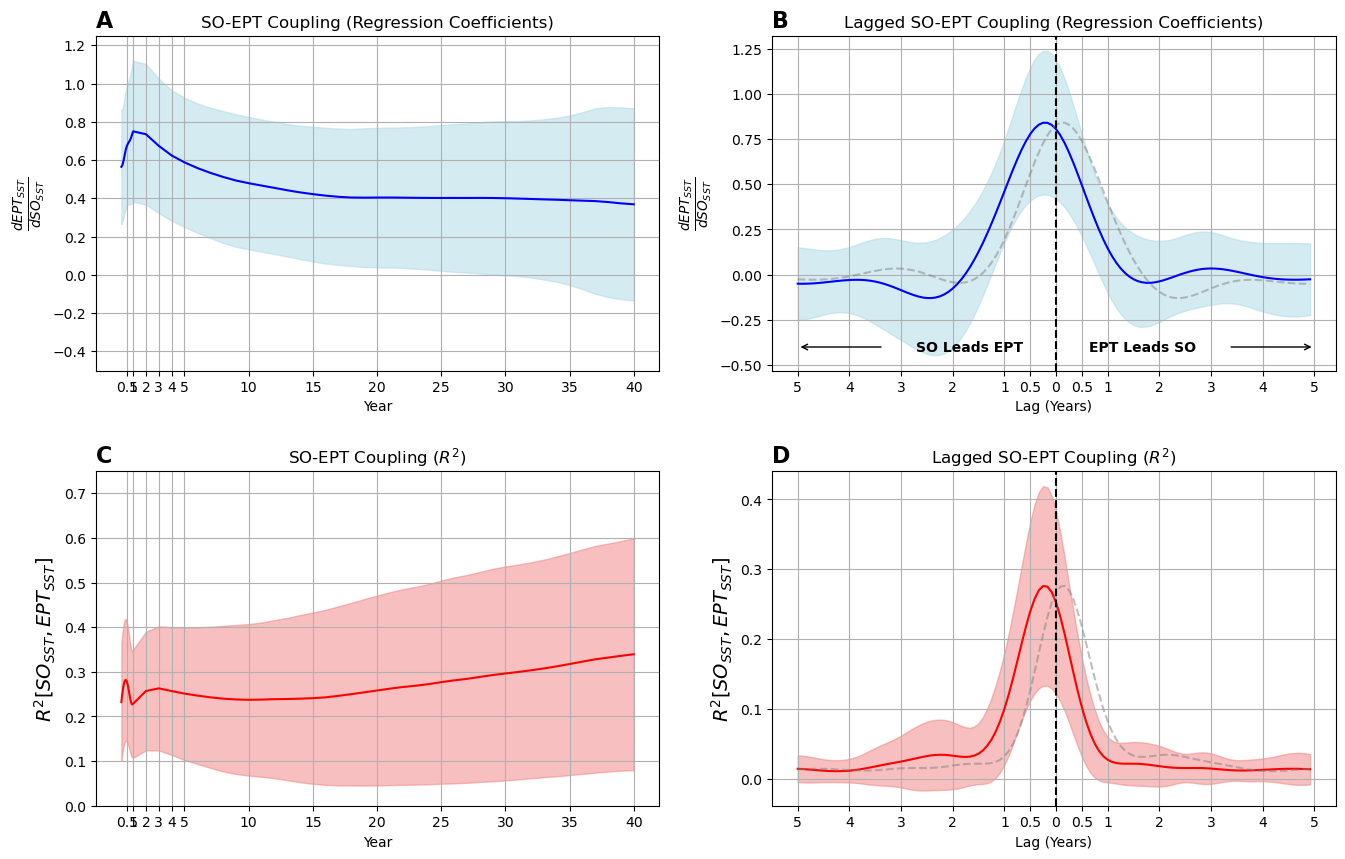

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Calculate the mean and standard deviation of rvalues_so_ept_coupling
mean_reg = rvalues_so_ept_coupling["reg"].mean(dim='model')
std_reg = rvalues_so_ept_coupling["reg"].std(dim='model')

mean_rvalues = (rvalues_so_ept_coupling["rvalues"]**2).mean(dim='model')
std_rvalues = (rvalues_so_ept_coupling["rvalues"]**2).std(dim='model')

# Calculate the upper and lower bounds for shading
upper_bound_reg = mean_reg + 1 * std_reg
lower_bound_reg = mean_reg - 1 * std_reg

upper_bound_rvalues = mean_rvalues + 1 * std_rvalues
lower_bound_rvalues = mean_rvalues - 1 * std_rvalues


# Plot rvalues_so_ept_coupling
axs[0, 0].plot(rvalues_so_ept_coupling.years, mean_reg, color='blue', label='Mean')
axs[0, 0].fill_between(rvalues_so_ept_coupling.years, lower_bound_reg, upper_bound_reg, color='lightblue', alpha=0.5, label='2-sigma')
axs[0, 0].set_xticks([6, 12, 24, 36, 48, *years[::-5]], labels=[.5, 1, 2, 3, 4, *np.arange(min_year, max_year+1)[::-5]])
axs[0, 0].set_ylim(-.5, 1.25)
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel(r'$\frac{d EPT_{SST}}{d SO_{SST}}$', fontsize=14)
axs[0, 0].set_title(r'SO-EPT Coupling (Regression Coefficients)')
axs[0, 0].grid()

# Plot lag_so_ept_coupling
axs[0, 1].plot(lags, lagged_so_ept_coupling["reg"].mean(dim='model'), color='blue', label='Model Mean')
# reverse lagged_so_ept_coupling
reversed_lagged_so_ept_coupling = lagged_so_ept_coupling["reg"].mean(dim='model').values[::-1]
axs[0, 1].plot(lags, reversed_lagged_so_ept_coupling, color='gray', linestyle='--', alpha=0.5, label="Mirrored")
axs[0, 1].fill_between(lags, lagged_so_ept_coupling["reg"].mean(dim='model') - lagged_so_ept_coupling["reg"].std(dim='model'), lagged_so_ept_coupling["reg"].mean(dim='model') + lagged_so_ept_coupling["reg"].std(dim='model'), color='lightblue', alpha=0.5, label='2-sigma')
axs[0, 1].set_xlabel('Lag (Years)')
axs[0, 1].set_ylabel(r'$\frac{d EPT_{SST}}{d SO_{SST}}$', fontsize=14)
axs[0, 1].set_title('Lagged SO-EPT Coupling (Regression Coefficients)')
axs[0, 1].set_xticks([-60, -48, -36, -24, -12, -6, 0, 6, 12, 24, 36, 48, 60], labels=[5, 4, 3, 2, 1, .5, 0, .5, 1, 2, 3, 4, 5])
axs[0, 1].grid()

# Add text below x axis with arrows
axs[0, 1].text(-20, -0.4, "SO Leads EPT", ha='center', va='center', fontweight="bold") #, fontsize=axis_fontsize)
axs[0, 1].annotate("", xy=(-60, -0.4), xytext=(-40, -0.4), arrowprops=dict(arrowstyle="->"))
axs[0, 1].text(20, -0.4, "EPT Leads SO", ha='center', va='center', fontweight="bold") #, fontsize=axis_fontsize)
axs[0, 1].annotate("", xy=(60, -0.4), xytext=(40, -0.4), arrowprops=dict(arrowstyle="->"))

# Add vertical line at 0
axs[0, 1].axvline(0, color='black', linestyle='--')

# Plot rvalues_so_ept_coupling
axs[1, 0].plot(rvalues_so_ept_coupling.years, mean_rvalues, color='red', label='Mean')
axs[1, 0].fill_between(rvalues_so_ept_coupling.years, lower_bound_rvalues, upper_bound_rvalues, color='lightcoral', alpha=0.5, label='2-sigma')
axs[1, 0].set_xticks([6, 12, 24, 36, 48, *years[::-5]], labels=[.5, 1, 2, 3, 4, *np.arange(min_year, max_year+1)[::-5]])
axs[1, 0].set_ylim(0, .75)
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel(r'$R^2[SO_{SST}, EPT_{SST}]$', fontsize=14)
axs[1, 0].set_title(r'SO-EPT Coupling ($R^2$)')
axs[1, 0].grid()

# Plot lagged_so_ept_coupling
axs[1, 1].plot(lags, (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model') , color='red', label='Mean')
axs[1, 1].fill_between(lags, (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model') - (lagged_so_ept_coupling["rvalues"]**2).std(dim='model'), (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model') + (lagged_so_ept_coupling["rvalues"]**2).std(dim='model'), color='lightcoral', alpha=0.5, label='2-sigma')
reversed_lagged_so_ept_coupling = (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model').values[::-1]
axs[1, 1].plot(lags, reversed_lagged_so_ept_coupling, color='gray', linestyle='--', alpha=0.5, label="Mirrored")
axs[1, 1].set_xlabel('Lag (Years)')
axs[1, 1].set_xticks([-60, -48, -36, -24, -12, -6, 0, 6, 12, 24, 36, 48, 60], labels=[5, 4, 3, 2, 1, .5, 0, .5, 1, 2, 3, 4, 5])
axs[1, 1].set_ylabel(r'$R^2[SO_{SST}, EPT_{SST}]$', fontsize=14)
axs[1, 1].set_title('Lagged SO-EPT Coupling ($R^2$)')
axs[1, 1].grid()
axs[1, 1].axvline(0, color='black', linestyle='--')

axs[0, 0].set_title('A', loc="left", fontweight="bold", fontsize=16)
axs[0, 1].set_title('B', loc="left", fontweight="bold", fontsize=16)
axs[1, 0].set_title('C', loc="left", fontweight="bold", fontsize=16)
axs[1, 1].set_title('D', loc="left", fontweight="bold", fontsize=16)
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3) #, wspace=0.3)

# Show the plot
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/so_ept_coupling_lagged_and_timescale.png")
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/so_ept_coupling_lagged_and_timescale.pdf")

# SO-EPT Coupling Explained by SWCF

In [12]:
def make_cyclic(ds):
    ds_end = ds.isel(lon=-1)
    ds_end["lon"] = 180
    ds_beg = ds.isel(lon=0)
    ds_beg["lon"] = -180
    ds_beg
    ds = xr.concat([ds_beg, ds, ds_end], dim="lon")
    return ds

rvalues_so_ept_coupling, swcf_cmip = get_shared_models(rvalues_so_ept_coupling, swcf_cmip)
r = xscore.pearson_r(rvalues_so_ept_coupling["reg"].sel(years=12*5), swcf_cmip["swcf"], dim="model", skipna=True)
p = xscore.pearson_r_eff_p_value(rvalues_so_ept_coupling["reg"].sel(years=12*5), swcf_cmip["swcf"], dim="model", skipna=True)

r2 = make_cyclic(r**2)
p = make_cyclic(p)

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['model'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site

/tmp/ipykernel_234994/3600420704.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


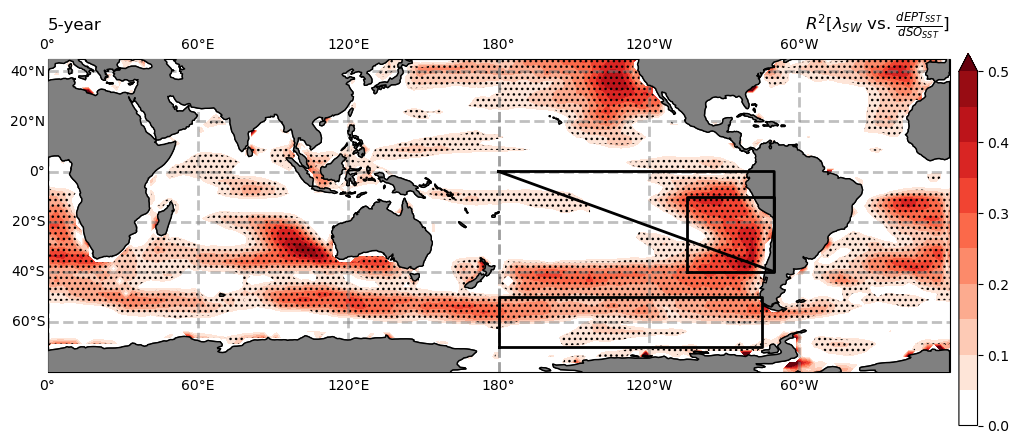

In [209]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=r2.values,
    pvalues=p,
    lat=r2.lat,
    lon=r2.lon,
    levels=np.arange(0, .55, .05),
    cmap="Reds",
    cbar_label="K/30yr"
)
ax1.set_title(r"$R^2[\lambda_{SW}$ vs. $\frac{dEPT_{SST}}{dSO_{SST}}]$", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("r2_swcf_vs_ept-so-coupling_5year.png", dpi=300, bbox_inches="tight")

# Repeat with Trends

In [118]:
so_ept_trend_coupling = xscore.linslope(sst_so_cmip, sst_ept_cmip, dim="time")
so_ept_trend_coupling, swcf_cmip = get_shared_models(so_ept_trend_coupling, swcf_cmip)
r2_trend = xscore.pearson_r(so_ept_trend_coupling, swcf_cmip["swcf"], dim="model", skipna=True)
p_trend = xscore.pearson_r_eff_p_value(so_ept_trend_coupling, swcf_cmip["swcf"], dim="model", skipna=True)

r2_trend = make_cyclic(r2_trend**2)
p_trend = make_cyclic(p_trend)

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['model'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site

/tmp/ipykernel_234994/3600420704.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


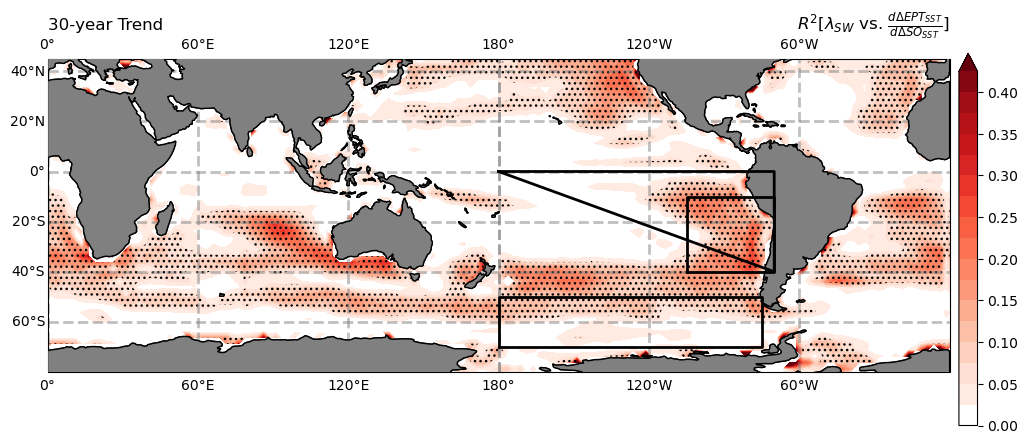

In [119]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=r2_trend.values,
    pvalues=p_trend,
    lat=r2_trend.lat,
    lon=r2_trend.lon,
    levels=np.arange(0, .450, .025),
    cmap="Reds",
    cbar_label="K/30yr"
)
ax1.set_title(r"$R^2[\lambda_{SW}$ vs. $\frac{d \Delta EPT_{SST}}{d \Delta SO_{SST}}]$", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"30-year Trend", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("r2_swcf_vs_ept-so-coupling_30year-trend.png", dpi=300, bbox_inches="tight")

In [27]:
cmip_ssts = xr.concat([cmip6_monthly_ssts.resample(time="5Y").mean(), cmip5_monthly_ssts.resample(time="5Y").mean()], dim="model")
cmip_ssts = cmip_ssts.std("time")


In [32]:
so_ept_trend_coupling = xscore.linslope(sst_so_cmip, sst_ept_cmip, dim="time")
so_ept_trend_coupling, cmip_ssts = get_shared_models(so_ept_trend_coupling, cmip_ssts)
r2_trend = xscore.pearson_r(so_ept_trend_coupling, cmip_ssts["tos"], dim="model", skipna=True)
p_trend = xscore.pearson_r_eff_p_value(so_ept_trend_coupling, cmip_ssts["tos"], dim="model", skipna=True)

r2_trend = make_cyclic(r2_trend**2)
p_trend = make_cyclic(p_trend)
r2_trend
p_trend

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['model'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site

<xarray.DataArray (lat: 72, lon: 146)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.80242965, 0.80242965, 0.78913696, ..., 0.80515357, 0.81166317,
        0.81166317],
       [0.88735189, 0.88735189, 0.89996423, ..., 0.87868844, 0.87660061,
        0.87660061],
       [0.84599424, 0.84599424, 0.84577752, ..., 0.85073642, 0.84068333,
        0.84068333]])
Coordinates:
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 -180.0 -178.8 -176.2 -173.8 ... 176.2 178.8 180.0

/tmp/ipykernel_870114/334533517.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


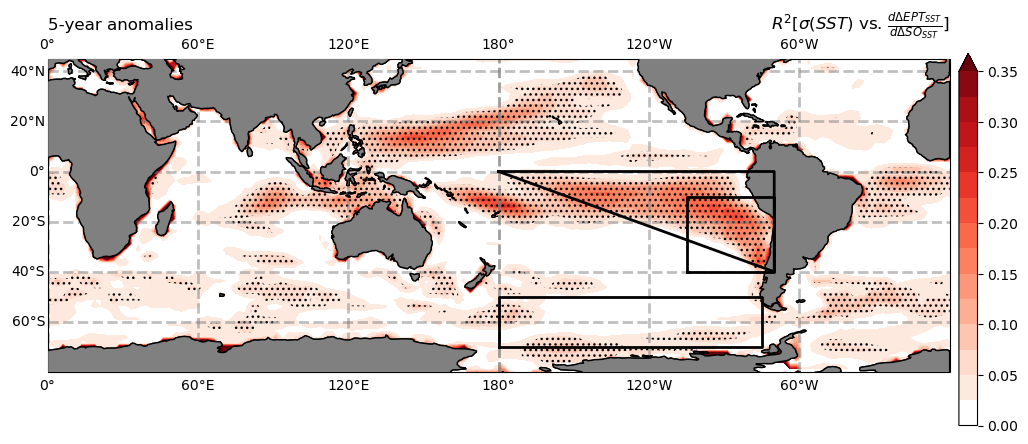

In [40]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=r2_trend.values,
    pvalues=p_trend,
    lat=r2_trend.lat,
    lon=r2_trend.lon,
    levels=np.arange(0, .375, .025),
    cmap="Reds",
    cbar_label="K/30yr"
)
ax1.set_title(r"$R^2[\sigma(SST)$ vs. $\frac{d \Delta EPT_{SST}}{d \Delta SO_{SST}}]$", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year anomalies", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("r2_sst_variance_vs_ept-so-coupling_30year-trend.png", dpi=300, bbox_inches="tight")
plt.savefig("r2_sst_variance_vs_ept-so-coupling_30year-trend.pdf", dpi=300, bbox_inches="tight")

0.572 0.0


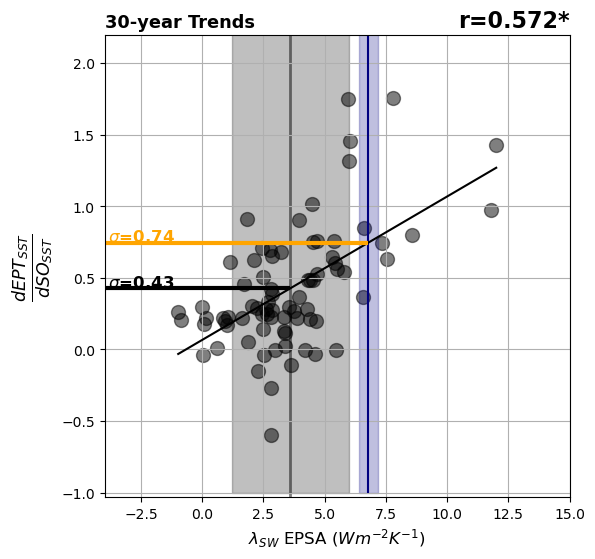

In [123]:
obs_swcf = [7.00834229, 7.2915155, 6.78656787, 6.65187705, 6.13171316]
rval, swcf_cmip_epsa = get_shared_models(so_ept_trend_coupling, swcf_cmip_epsa)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    swcf_cmip_epsa.values, 
    rval.values,
    vline=obs_swcf 
)
ax.grid()
ax.set_xlabel(r"$\lambda_{SW}$ EPSA ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
ax.set_ylabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_title("30-year Trends", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("line_swcf_vs_ept-so-coupling_30year-trend.png", dpi=300, bbox_inches="tight")

# Scatter Plots

In [15]:
def create_panel_a(ax, x6, y6, x5: list = [], y5: list = [], vline=0) -> None:
    # Set the default color cycle
    colors = ['black','maroon','#7570b3']
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

    CMIP6_label = "CMIP6"
    
    if len(x5) != 0: 
        slope, intercept, r, p, _ = linregress(x5,y5)
        r, p = np.around(r, 3), np.around(p, 3)
        CMIP5_label = f"r={r}"
        ax.scatter(x5, y5, s=100, alpha=.5, edgecolor="black", color=colors[0], label=CMIP5_label)

        slope, intercept, r, p, _ = linregress(x6,y6)
        r, p = np.around(r, 3), np.around(p, 3)
        CMIP6_label = f"r={r}"
    
    ax.scatter(x6, y6, s=100, alpha=.5, edgecolor="black", color=colors[0], label=CMIP6_label)

    # Vertical line for avg and std of obs
    ax.vlines(np.mean(vline), ymin=-1.0, ymax=2.5, color="navy")
    ax.fill_between(x=[np.mean(vline) - np.std(vline), np.mean(vline) + np.std(vline)], y1=-1, y2=2.5, color="navy", alpha=.25)

    # Multimodel mean
    mmm = np.mean([*x5, *x6])


    x = np.concatenate((x6, x5))
    y = np.concatenate((y6, y5))
    # Sort the lists together based on list1
    x, y  = zip(*sorted(zip(x, y)))

    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    if p < .05: 
        sig = '*'
    else: 
        sig = ''
    print(r, p)

    x = np.array(sorted(x))
    ax.plot(x, x*slope+intercept, color="black")
    # ax.legend(loc="upper left", fontsize=fontsize)
    ax.set_title(f"r={r}{sig}", loc="right", fontweight="bold", fontsize=16)
    
    
    # Define border size - important for emphasizing relationships
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    borderx, bordery = .25*abs(np.max(x)), .25*abs(np.max(y))
    ax.set_xlim(xmin-borderx, xmax+borderx)
    ax.set_ylim(ymin-bordery, ymax+bordery)


    # Add Model Vertical Lines
    ax.vlines(mmm, ymin=ymin-bordery, ymax=ymax+bordery, color=colors[0], label='_nolegend_', alpha=.5, linewidth=2, zorder=0) 
    # ax.fill_between(x=[mmm - np.std(x), mmm + np.std(x)], y1=-1, y2=2.5, color="black", alpha=.25)
    ax.fill_between(x=[mmm - np.std(x), mmm + np.std(x)], y1=np.min(y)*5-50, y2=np.max(y)*5+50, color="black", alpha=.25)

    # Add horizontal sigma lines
    sig_mmm = mmm*slope+intercept
    sig_obs = np.mean(vline)*slope+intercept
    hline_width = 3
    ax.hlines(y=sig_mmm, xmin=xmin-borderx, xmax=mmm, color="black", linewidth=hline_width)
    ax.hlines(y=sig_obs, xmin=xmin-borderx, xmax=np.mean(vline), color="orange", linewidth=hline_width)

    ax.text(s=f"{np.around(sig_mmm, 2)}", x=xmin-borderx*.95, y=sig_mmm + sig_mmm*.025, color="black", fontsize=12, fontweight="bold")
    ax.text(s=f"{np.around(sig_obs, 2)}", x=xmin-borderx*.95, y=sig_obs + sig_mmm*.025, color="orange", fontsize=12, fontweight="bold")

In [ ]:
obs_swcf = [7.00834229, 7.2915155, 6.78656787, 6.65187705, 6.13171316]
rval, swcf_cmip_epsa = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=12*5), swcf_cmip_epsa)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    swcf_cmip_epsa.values, 
    rval.values,
    vline=obs_swcf 
)
ax.grid()
ax.set_xlabel(r"$\lambda_{SW}$ EPSA ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
ax.set_ylabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_title("5-year Anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("line_swcf_vs_ept-so-coupling_5year.png", dpi=300, bbox_inches="tight")

In [202]:
for yr in rvalues_so_ept_coupling.years:
    rval, swcf_cmip_epsa = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=yr), swcf_cmip_epsa)
    reg = linregress(swcf_cmip_epsa.values, rval.values)
    print(yr.values, reg.rvalue)

1 0.3335879877840655
2 0.35523652187681676
3 0.37875696019743493
4 0.40805010654372514
5 0.4258656480796585
6 0.43692736496846835
7 0.4446804511001412
8 0.4513791134538648
9 0.45795332710261477
10 0.4658226975816101
11 0.47225897841076797
12 0.47604907898553156
24 0.535597875730509
36 0.6145834488979357
48 0.674080268432592
60 0.6901012804178418
72 0.6835311160506282
84 0.6770170271086582
96 0.6738825784569463
108 0.6628962094982154
120 0.6434514625274924
132 0.626460573847351
144 0.6126253087670269
156 0.5949457711166177
168 0.5749540802445993
180 0.556270486481433
192 0.5401414504111611
204 0.5226018621000794
216 0.5004628733728689
228 0.48063691410229936
240 0.4662042525078687
252 0.45208171802412384
264 0.43659874412069277
276 0.4219436629387629
288 0.40857401226235135
300 0.3941979467698298
312 0.3783753381049227
324 0.3613134487950956
336 0.34349328939700896
348 0.32597668253625933
360 0.3097201924668962
372 0.2953953361095201
384 0.2832313734231405
396 0.2705322902718002
408 0.2

# Examine Relationship between Internal Variability and Magnitude of Coupling

## Coupling vs. Variance EPT Ocean

0.752 0.0


Text(0.0, 1.0, '5-year Anoms')

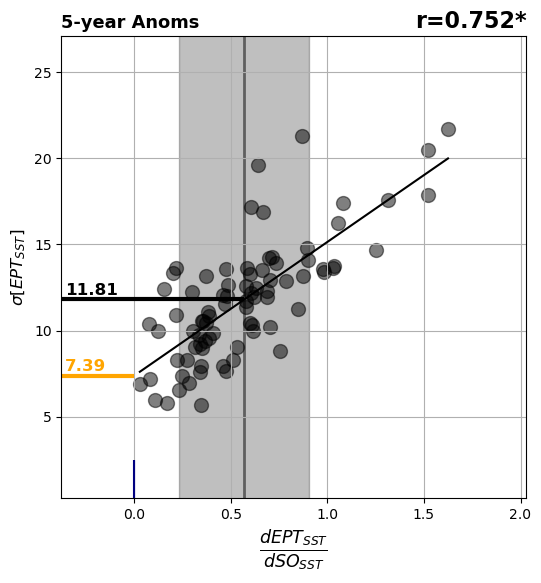

In [21]:
# Coupling vs. Variance SO
# for yr in rvalues_so_ept_coupling.years:
#     reg = linregress(rvalues_so_ept_coupling.reg.sel(years=yr), rvalues_so_ept_coupling.variance_ept.sel(years=yr))
#     print(yr.values, reg.rvalue)
yr = 12*5
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    rvalues_so_ept_coupling.reg.sel(years=yr),
    rvalues_so_ept_coupling.variance_ept.sel(years=yr),
    vline=[0,0,0]
)
ax.grid()
ax.set_ylabel(r"$\sigma[EPT_{SST}]$", fontsize=axis_fontsize)
ax.set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_title("5-year Anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/ept5yr_variance_vs_ept-so-coupling_5year.png", dpi=300, bbox_inches="tight")

## Coupling vs. Variance Southern Ocean

1 -0.2744688177261168
2 -0.26616098306063174
3 -0.26128477388778465
4 -0.2521471332223145
5 -0.23501902158836074
6 -0.21372473161831562
7 -0.20188087586985234
8 -0.19890860151174755
9 -0.2026638983904381
10 -0.20695477711111906
11 -0.20667782170794904
12 -0.20956943852907947
24 -0.2410498959757322
36 -0.2534064892073067
48 -0.2552462471358449
60 -0.25401654825753334
72 -0.25674731616260393
84 -0.2529180991988977
96 -0.24354110676520588
108 -0.239575502125111
120 -0.24107932667149062
132 -0.24097991963150428
144 -0.23415917632574615
156 -0.22275804948060776
168 -0.20919369591399134
180 -0.1973329426990992
192 -0.18869074834549715
204 -0.18244336942743347
216 -0.17918323674185982
228 -0.18068112461791522
240 -0.18586159776438893
252 -0.19153911849961386
264 -0.196323147560306
276 -0.19901951899516504
288 -0.1994739359379882
300 -0.20003630832020985
312 -0.20152561621796994
324 -0.2023465039044139
336 -0.20403718094179193
348 -0.2043058329998692
360 -0.20241935821350215
372 -0.19880104404

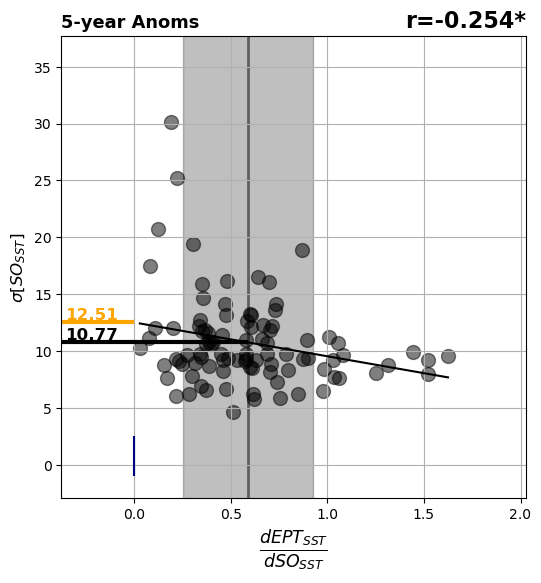

In [265]:
# Coupling vs. Variance SO
for yr in rvalues_so_ept_coupling.years:
    reg = linregress(rvalues_so_ept_coupling.reg.sel(years=yr), rvalues_so_ept_coupling.variance_so.sel(years=yr))
    print(yr.values, reg.rvalue)

yr = 12*5
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    rvalues_so_ept_coupling.reg.sel(years=yr),
    rvalues_so_ept_coupling.variance_so.sel(years=yr),
    vline=[0,0,0]
)
ax.grid()
ax.set_ylabel(r"$\sigma[SO_{SST}]$", fontsize=axis_fontsize)
ax.set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_title("5-year Anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/so5yr_variance_vs_ept-so-coupling_5year.png", dpi=300, bbox_inches="tight")

# Examine Relationship between Forced Response, Internal Variability, Coupling, and SWCF

My hunch is that the magnitude of the forced response in the Southern Ocean is related to the magnitude of the forced response in the EPT, such that models with amplified SO warming tend to have amplified EPT warming and vise versa. 
- The figure below seems to suggest that this is true but a weak constraint. 

0.324 0.005


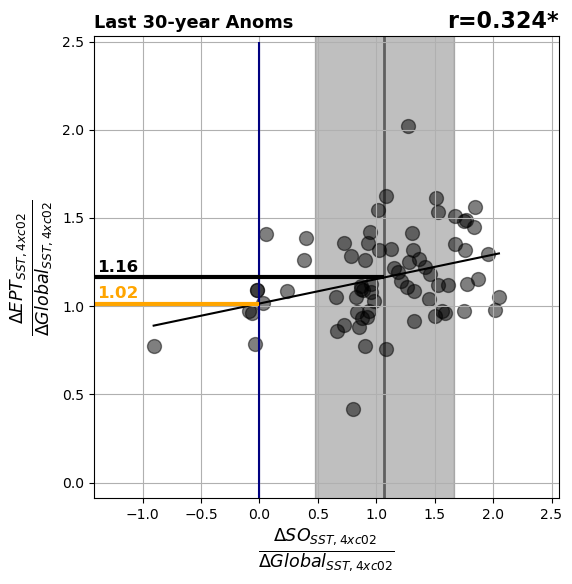

In [301]:
# Last 30 years
ept_warming = cmip_4xc02_ept_sst.isel(time=slice(1800-12*30, 1800)).mean("time")["tos"] - cmip_4xc02_ept_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]
global_warming = cmip_4xc02_global_sst.isel(time=slice(1800-12*30, 1800)).mean(dim="time")["tos"] - cmip_4xc02_global_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]
so_warming = cmip_4xc02_so_sst.isel(time=slice(1800-12*30, 1800)).mean("time")["tos"] - cmip_4xc02_so_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]

ept_warming = ept_warming / global_warming
so_warming = so_warming / global_warming

so_warming = so_warming.where(ept_warming != ept_warming.max(), drop=True)
ept_warming = ept_warming.where(ept_warming != ept_warming.max(), drop=True)

# plot ept warming vs. so warming
obs_swcf = [0,0]
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    so_warming, 
    ept_warming,
    vline=obs_swcf 
)
ax.grid()
ax.set_ylabel(r"$\frac{\Delta EPT_{SST,4xc02}}{\Delta Global_{SST,4xc02}}$", fontsize=axis_fontsize*1.5) 
ax.set_xlabel(r"$\frac{\Delta SO_{SST,4xc02}}{\Delta Global_{SST,4xc02}}$", fontsize=axis_fontsize*1.5) 
ax.set_title("Last 30-year Anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/ept_so_coupled_warming_4xc02_last30yr-anoms.png", dpi=300, bbox_inches="tight")

0.306 0.009


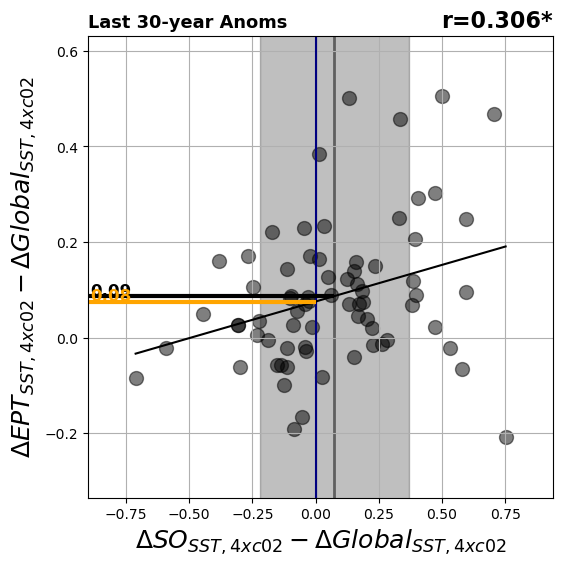

In [305]:
# Last 30 years
ept_warming = cmip_4xc02_ept_sst.isel(time=slice(1800-12*30, 1800)).mean("time")["tos"] - cmip_4xc02_ept_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]
global_warming = cmip_4xc02_global_sst.isel(time=slice(1800-12*30, 1800)).mean(dim="time")["tos"] - cmip_4xc02_global_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]
so_warming = cmip_4xc02_so_sst.isel(time=slice(1800-12*30, 1800)).mean("time")["tos"] - cmip_4xc02_so_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]

ept_warming = ept_warming - global_warming
so_warming = so_warming - global_warming

so_warming = so_warming.where(ept_warming != ept_warming.max(), drop=True)
ept_warming = ept_warming.where(ept_warming != ept_warming.max(), drop=True)

# plot ept warming vs. so warming
obs_swcf = [0,0]
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    so_warming, 
    ept_warming,
    vline=obs_swcf 
)
ax.grid()
ax.set_ylabel(r"$\Delta EPT_{SST,4xc02} - \Delta Global_{SST,4xc02}$", fontsize=axis_fontsize*1.5) 
ax.set_xlabel(r"$\Delta SO_{SST,4xc02} - \Delta Global_{SST,4xc02}$", fontsize=axis_fontsize*1.5) 
ax.set_title("Last 30-year Anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/ept_so_coupled_warming_4xc02_diffs.png", dpi=300, bbox_inches="tight")

We may also postulate that models with larger piControl SO-EPT coupling also have more coupled rates of warming.

-0.085 0.493


Text(0.0, 1.0, 'Last 30-year Anoms')

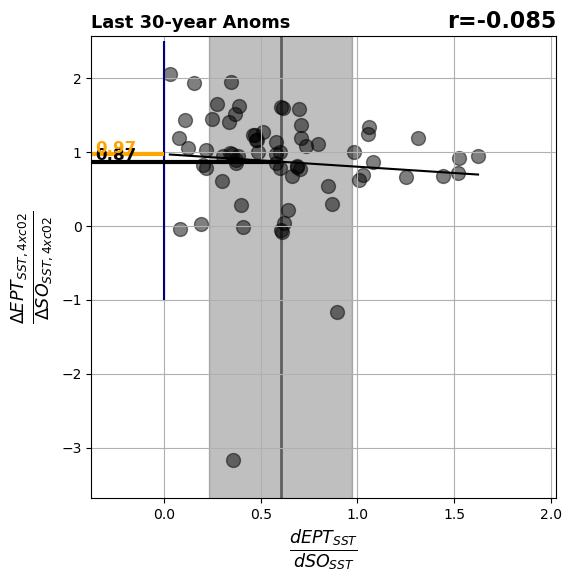

In [313]:
# Last 30 years
ept_warming = cmip_4xc02_ept_sst.isel(time=slice(1800-12*30, 1800)).mean("time")["tos"] - cmip_4xc02_ept_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]
global_warming = cmip_4xc02_global_sst.isel(time=slice(1800-12*30, 1800)).mean(dim="time")["tos"] - cmip_4xc02_global_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]
so_warming = cmip_4xc02_so_sst.isel(time=slice(1800-12*30, 1800)).mean("time")["tos"] - cmip_4xc02_so_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]

ept_warming = ept_warming #- global_warming
so_warming = so_warming #- global_warming

ratio_warming = so_warming / ept_warming
rval, ratio_warming = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=12*5), ratio_warming)


# plot ept warming vs. so warming
obs_swcf = [0,0]
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    rval, 
    ratio_warming,
    vline=obs_swcf 
)
ax.grid()
ax.set_ylabel(r"$\frac{\Delta EPT_{SST,4xc02}}{\Delta SO_{SST,4xc02}}$", fontsize=axis_fontsize*1.5) 
ax.set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_title("Last 30-year Anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
# plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/ept_so_coupled_warming_4xc02_diffs.png", dpi=300, bbox_inches="tight")

If the magnitude of the forced response in the SO and EPT are only weakly related, maybe the timing of the warming is more strongly related. I.e. models with delayed EPT warming also have delayed SO warming and vise versa....We can check this by changing the time-periods we're slicing

0.203 0.088


Text(0.5, 0, '$\\frac{\\Delta SO_{SST,4xc02}}{\\Delta Global_{SST,4xc02}}$')

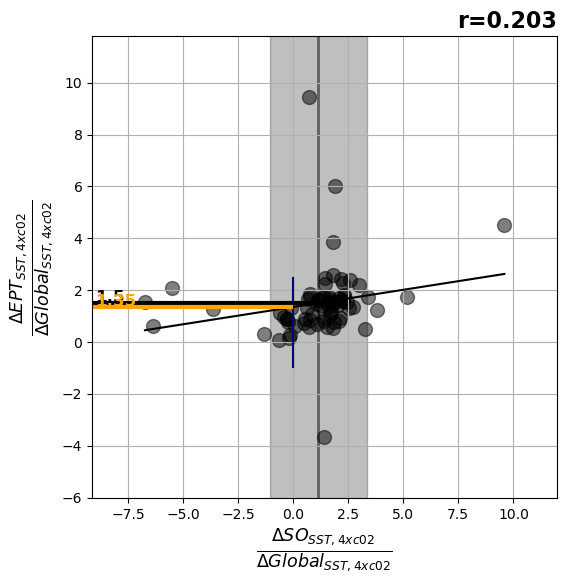

: 

In [315]:
# Last 30 years
ept_warming = cmip_4xc02_ept_sst.isel(time=slice(12*30, 2*12*30)).mean("time")["tos"] - cmip_4xc02_ept_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]
global_warming = cmip_4xc02_global_sst.isel(time=slice(12*30, 2*12*30)).mean(dim="time")["tos"] - cmip_4xc02_global_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]
so_warming = cmip_4xc02_so_sst.isel(time=slice(12*30, 2*12*30)).mean("time")["tos"] - cmip_4xc02_so_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]

ept_warming = ept_warming / global_warming
so_warming = so_warming / global_warming

so_warming = so_warming.where(ept_warming != ept_warming.max(), drop=True)
ept_warming = ept_warming.where(ept_warming != ept_warming.max(), drop=True)

# plot ept warming vs. so warming
obs_swcf = [0,0]
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    so_warming, 
    ept_warming,
    vline=obs_swcf 
)
ax.grid()
ax.set_ylabel(r"$\frac{\Delta EPT_{SST,4xc02}}{\Delta Global_{SST,4xc02}}$", fontsize=axis_fontsize*1.5) 
ax.set_xlabel(r"$\frac{\Delta SO_{SST,4xc02}}{\Delta Global_{SST,4xc02}}$", fontsize=axis_fontsize*1.5) 
# ax.set_title("5-year Anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)

# Walker and ITCZ Related to SWCF

0.41 0.0


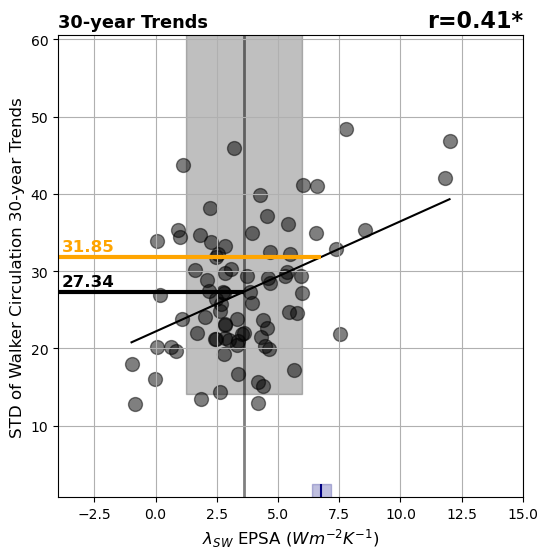

In [49]:
axis_fontsize = 12
title_fontsize = 16

obs_swcf = [7.00834229, 7.2915155, 6.78656787, 6.65187705, 6.13171316]
walker_30yr_trends_std, swcf_cmip_epsa = get_shared_models(walker_30yr_trends.std("time"), swcf_cmip_epsa)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    swcf_cmip_epsa.values, 
    walker_30yr_trends_std.values,
    vline=obs_swcf 
)
ax.grid()
ax.set_xlabel(r"$\lambda_{SW}$ EPSA ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
ax.set_ylabel(r"STD of Walker Circulation 30-year Trends", fontsize=axis_fontsize*1) 
ax.set_title("30-year Trends", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/swcf_epsa_vs_std_30year-WalkerCirc_trend.png", dpi=300, bbox_inches="tight")

0.6 0.0


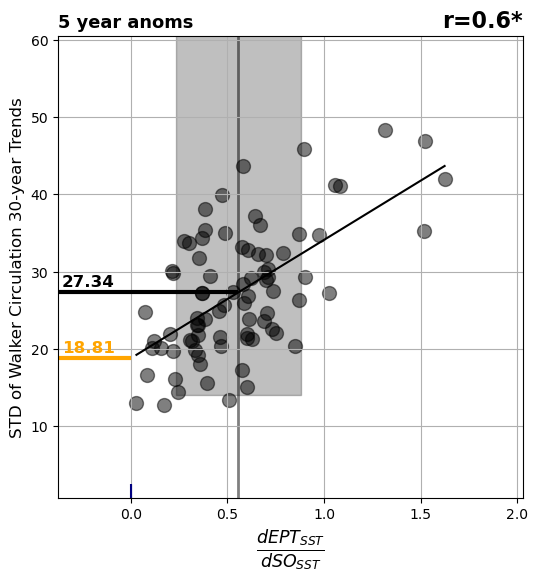

In [51]:
axis_fontsize = 12
title_fontsize = 16

rval, walker_30yr_trends_std = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=12*5), walker_30yr_trends_std)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    rval.values, 
    walker_30yr_trends_std.values,
    vline=[0,0,0]
)
ax.grid()
ax.set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_ylabel(r"STD of Walker Circulation 30-year Trends", fontsize=axis_fontsize*1) 
ax.set_title("5 year anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/EPT-SO_coupling_vs_std_30year-WalkerCirc_trend.png", dpi=300, bbox_inches="tight")

# ITCZ Precip

In [ ]:
axis_fontsize = 12
title_fontsize = 16

obs_swcf = [7.00834229, 7.2915155, 6.78656787, 6.65187705, 6.13171316]
paiep_clim_sm, swcf_cmip_epsa = get_shared_models(paiep_clim, swcf_cmip_epsa)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    swcf_cmip_epsa.values, 
    paiep_clim_sm.values,
    vline=obs_swcf 
)
ax.grid()
ax.set_xlabel(r"$\lambda_{SW}$ EPSA ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
ax.set_ylabel(r"ITCZ (Precipitation Asymmetry Index)", fontsize=axis_fontsize*1) 
ax.set_title("", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)

0.508 0.0


Text(0.0, 1.0, '')

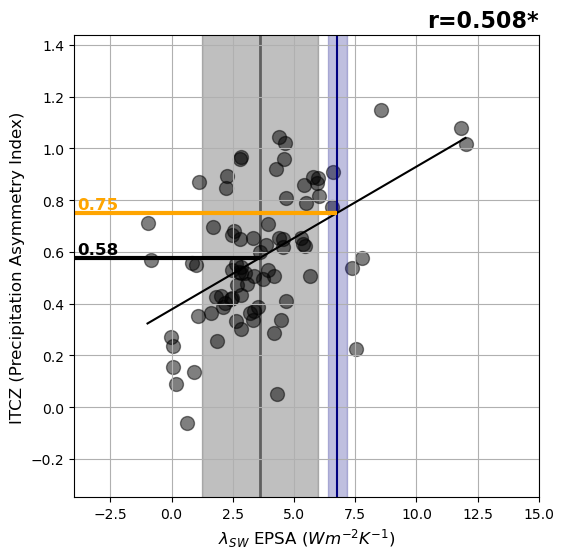

In [16]:
axis_fontsize = 12
title_fontsize = 16

obs_swcf = [7.00834229, 7.2915155, 6.78656787, 6.65187705, 6.13171316]
paiep_clim_sm, swcf_cmip_epsa = get_shared_models(paiep_clim, swcf_cmip_epsa)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    swcf_cmip_epsa.values, 
    paiep_clim_sm.values,
    vline=obs_swcf 
)
ax.grid()
ax.set_xlabel(r"$\lambda_{SW}$ EPSA ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
ax.set_ylabel(r"ITCZ (Precipitation Asymmetry Index)", fontsize=axis_fontsize*1) 
ax.set_title("", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
# plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/swcf_epsa_vs_itcz_pai_clim.png", dpi=300, bbox_inches="tight")

In [20]:
for yr in rvalues_so_ept_coupling.years:
    rval, paiep_clim_sm = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=yr), paiep_clim)
    reg = linregress(paiep_clim_sm.values, rval.values)
    print(yr.values, reg.rvalue)

1 0.31949177437972875
2 0.3394782802298456
3 0.3604175049567682
4 0.3856865240229628
5 0.40466292461297637
6 0.42645387647905414
7 0.4462797615736346
8 0.46551386033381564
9 0.4816040590548712
10 0.4916139575984471
11 0.4889372309393603
12 0.48142742352120477
24 0.49996152422619444
36 0.5184516305520573
48 0.519890863690202
60 0.4952403035432837
72 0.45908469996440987
84 0.4279268891576368
96 0.4027143651025675
108 0.379304312785813
120 0.3571108255903599
132 0.34042172964535816
144 0.33008755271098694
156 0.3169458248734587
168 0.30180753804845606
180 0.2909838411547907
192 0.2833778360301151
204 0.273806991080145
216 0.2580136796483839
228 0.24305411492000442
240 0.2361556577541428
252 0.2310884130740195
264 0.22457902093684773
276 0.22229848799844978
288 0.22356653679955926
300 0.22256465061069586
312 0.21817919030684396
324 0.21635540822851637
336 0.21771301288028191
348 0.21872368507211995
360 0.21778709286298753
372 0.21803075489321141
384 0.21653124082454797
396 0.21486203861051

0.495 0.0


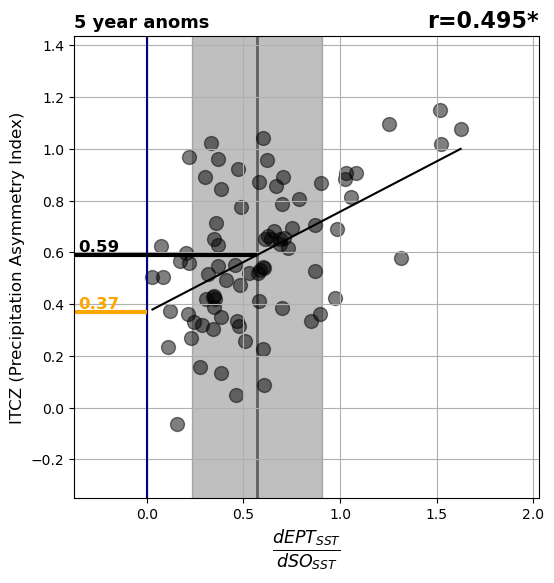

In [18]:
axis_fontsize = 12
title_fontsize = 16

rval, paiep_clim_sm = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=12*5), paiep_clim)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    rval.values, 
    paiep_clim_sm.values,
    vline=[0,0] #obs_swcf 
)
ax.grid()
ax.set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_ylabel(r"ITCZ (Precipitation Asymmetry Index)", fontsize=axis_fontsize*1) 
ax.set_title("5 year anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
# ax.set_title("", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/coupling_vs_itcz_pai_clim.png", dpi=300, bbox_inches="tight")